<h1>SI 370 Homework 6</h1>
Haley Johnson

This notebook utilizes machine learning techniques to detect fake news. The original dataset comes from <a href = "https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset">Kaggle</a> and contains 21,417 real news articles and 23,481 fake news articles. After removing duplicates, the final dataset consisted of 39,105 entries.

In this notebook, I compare the performances of an Extra Trees Model and Support Vector Machine model with TF-IDF inputs and a Multi Layer Perceptron with BERT embedding inputs. 

In [3]:
# pip install -U sentence-transformers

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

from sentence_transformers import SentenceTransformer

In [4]:
sns.set(context = 'notebook', style = 'darkgrid')

<h2>Load in Dataset</h2>

In [5]:
fake = pd.read_csv('Fake.csv', encoding = 'utf-8')
true = pd.read_csv('True.csv', encoding = 'utf-8')

In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
true['label'] = 1
fake['label'] = 0
df = pd.concat([true, fake])
df = df.reset_index(drop = True)

In [22]:
true.shape, fake.shape

((21417, 5), (23481, 5))

<h2>Exploratory Data Analysis</h2>

There are no missing values in the dataset

In [9]:
for col in df.columns:
    print(f"Missing values in '{col}': {pd.isnull(df[col]).sum()}")

Missing values in 'title': 0
Missing values in 'text': 0
Missing values in 'subject': 0
Missing values in 'date': 0
Missing values in 'label': 0


However, there are 5305 duplicate rows. We'll remove duplicates from the dataframe, so there's only one entry per story.

In [10]:
counts = df.groupby(['title', 'text']).size().reset_index(name = 'count')
duplicates = counts[counts['count'] > 1]
duplicates.shape

(5305, 3)

In [11]:
df = df.drop_duplicates(['text', 'title'])

In [23]:
df.shape

(39105, 5)

This classes in the dataset are roughly balanced — 54.2% of the articles are real and 45.8% are fake. 

In [12]:
df.label.value_counts() / df.shape[0]

1    0.542053
0    0.457947
Name: label, dtype: float64

<h3>Article Subjects</h3>

There are 7 subjects represented in the dataset, but there are significant imbalances in how frequently they're used. Government News, left-news and US_News are almost never used. 

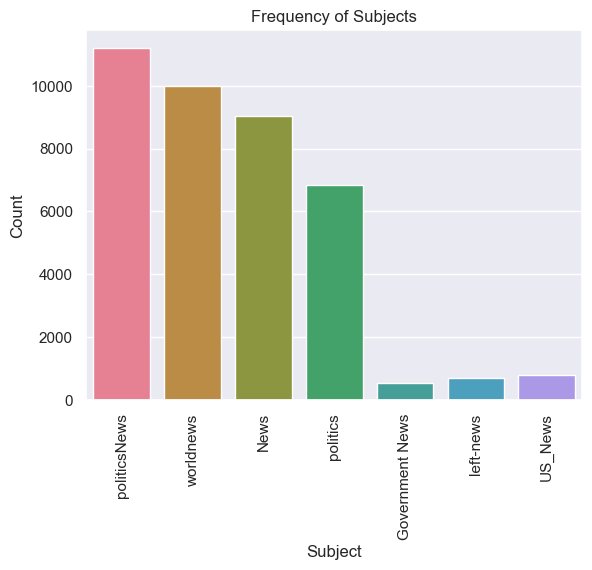

In [13]:
f = sns.countplot(x = 'subject', data = df, palette = sns.color_palette("husl", 8))
f.set(title = 'Frequency of Subjects', xlabel = 'Subject', ylabel = 'Count')

_ = plt.xticks(rotation = 90)

However, it appears that the subjects are not evenly distributed across fake and real news sources. In fact, real news articles use completely different subject labels than fake news. 

In [14]:
crosstab = pd.crosstab(df.label, df.subject)
crosstab

subject,Government News,News,US_News,left-news,politics,politicsNews,worldnews
label,,,,,,,
0,532,9050,783,705,6838,0,0
1,0,0,0,0,0,11217,9980


/var/folders/49/3f_15lzd6b57lnzlk4m_9k440000gn/T/ipykernel_5603/1827207376.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_crosstab = crosstab / crosstab.astype(float).sum(axis = 1)[:, np.newaxis]


[Text(0.5, 1.0, 'Subjects by Fake/Real Status'),
 Text(0.5, 19.909374999999997, 'Subject'),
 Text(47.25, 0.5, 'Category')]

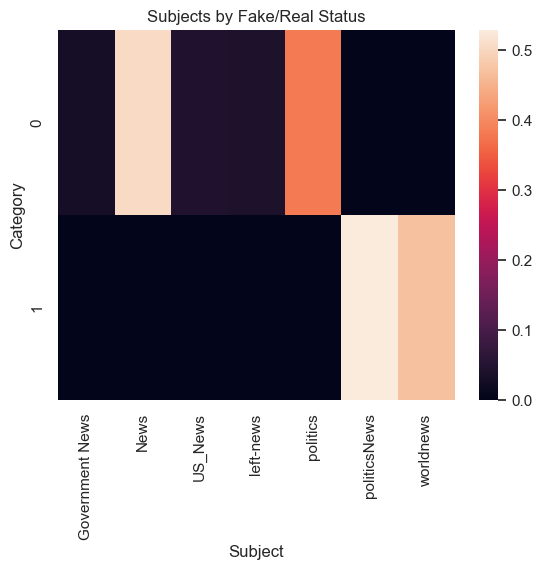

In [15]:
normalized_crosstab = crosstab / crosstab.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_crosstab)
f.set(title = 'Subjects by Fake/Real Status', xlabel = 'Subject', ylabel = 'Category')

<h2>Preprocess Text</h2>

To preprocess our text, we'll normalize it, remove punctuation, and remove URLS. The methodss we use later in this notebook to transform text into machine readable inputs (TF-IDF vectorization and BERT embeddings) will remove stopwords for us. 

In [16]:
def clean_text(s, punctuation = ['!', '?', '—', '/', '...', ",", "."]):
    '''
    Takes in text column dataframe and does basic preprocessing
    '''
    
    # make lower case 
    s = s.lower()
    
    # remove urls
    s = s.replace('http\S+', '')

    # fix the quotations
    s = s.replace('”', '"')
    s = s.replace('“', '"')
    s = s.replace('“', '"')
    s = s.replace('”', '"')
    s = s.replace("‘", "'")
    s = s.replace("’", "'")
    s = s.replace("‘", "'")
    s = s.replace("´", "'")
    s = s.replace("`", "'")
    
    # remove other punctuation 
    for p in punctuation:
        s = s.replace(p, '')
      
    return s

In [17]:
df.text = df.text.apply(clean_text)

<h2>Prepare Test and Train Data</h2>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state = 42)

In [19]:
tfidv = TfidfVectorizer(smooth_idf = False, sublinear_tf = False, norm = None, lowercase = True,
                        analyzer = 'word', stop_words = 'english')

X_train_tfidv = tfidv.fit_transform(X_train)
X_test_tfidv = tfidv.transform(X_test)

In [20]:
#note: this cell takes very long to run! avoid rerunning this!
bert_model = SentenceTransformer('mrm8488/bert-tiny-finetuned-squadv2', device = 'cpu')
embedding = FunctionTransformer(lambda s : bert_model.encode(s, convert_to_tensor = True, show_progress_bar = False)
                                .detach().numpy())

X_train_bert = embedding.fit_transform(X_train.to_numpy())
X_test_bert = embedding.transform(X_test.to_numpy())

No sentence-transformers model found with name /Users/haleyjohnson/.cache/torch/sentence_transformers/mrm8488_bert-tiny-finetuned-squadv2. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/haleyjohnson/.cache/torch/sentence_transformers/mrm8488_bert-tiny-finetuned-squadv2 were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h2>Extra Trees Classifier</h2>
Used in conjunction with TFIDV preprocessing

In [19]:
n_estimators = {'n_estimators': [50, 100, 150, 250, 500]}

extra_trees = ExtraTreesClassifier(random_state = 42)
extra_trees_clf = GridSearchCV(extra_trees, n_estimators, cv = 3, verbose = 3.1)

extra_trees_clf.fit(X_train_tfidv, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ...................n_estimators=50;, score=0.962 total time=17.5min
[CV 2/3] END ...................n_estimators=50;, score=0.963 total time= 6.2min
[CV 3/3] END ...................n_estimators=50;, score=0.962 total time= 2.4min
[CV 1/3] END ..................n_estimators=100;, score=0.966 total time= 2.9min
[CV 2/3] END ..................n_estimators=100;, score=0.969 total time=37.5min
[CV 3/3] END ..................n_estimators=100;, score=0.967 total time=85.0min
[CV 1/3] END ..................n_estimators=150;, score=0.968 total time=41.4min
[CV 2/3] END ..................n_estimators=150;, score=0.969 total time= 3.9min
[CV 3/3] END ..................n_estimators=150;, score=0.969 total time= 4.3min
[CV 1/3] END ..................n_estimators=250;, score=0.971 total time= 6.2min
[CV 2/3] END ..................n_estimators=250;, score=0.972 total time= 5.6min
[CV 3/3] END ..................n_estimators=250;,

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'n_estimators': [50, 100, 150, 250, 500]},
             verbose=3.1)

In [20]:
extra_trees_clf.best_params_, extra_trees_clf.best_score_

({'n_estimators': 500}, 0.9706764866339334)

The extra trees classifier achieves <b>96.92% accuracy</b> on the test data. False positives are more common than false negatives. In fact, very few real news articles were misclassified as fake.

In [21]:
extra_trees_clf.score(X_test_tfidv, y_test)

0.9692134601616038

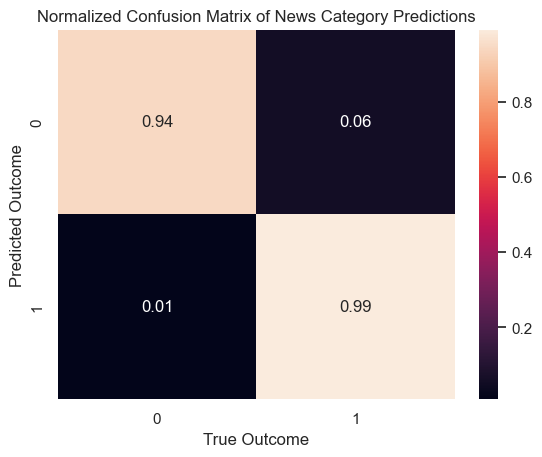

In [22]:
conf_matrix = confusion_matrix(y_test, extra_trees_clf.predict(X_test_tfidv))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt = '.2f')
_ = f.set(title = 'Normalized Confusion Matrix of News Category Predictions', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>Support Vector Classification</h2>
Used in conjunction with TFIDV preprocessing

In [23]:
estimators = {'gamma': ['scale',  'auto']}
svc = SVC(kernel = 'linear', random_state = 42)

svc_model = GridSearchCV(svc, estimators, cv = 3, verbose = 3.1)
svc_model.fit(X_train_tfidv, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END .......................gamma=scale;, score=0.986 total time= 3.1min
[CV 2/3] END .......................gamma=scale;, score=0.989 total time= 3.7min
[CV 3/3] END .......................gamma=scale;, score=0.986 total time= 3.1min
[CV 1/3] END ........................gamma=auto;, score=0.986 total time= 2.1min
[CV 2/3] END ........................gamma=auto;, score=0.989 total time= 2.7min
[CV 3/3] END ........................gamma=auto;, score=0.986 total time=27.3min


GridSearchCV(cv=3, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'gamma': ['scale', 'auto']}, verbose=3.1)

In [24]:
svc_model.best_params_, extra_trees_clf.best_score_

({'gamma': 'scale'}, 0.9706764866339334)

In [25]:
svc_model.score(X_test_tfidv, y_test)

0.9881354198629436

The support vector machine classifier achieved <b>98.81% accuracy</b> on the testing data. False positives were twice as common as false negatives, but articles were rarely misclassified. 

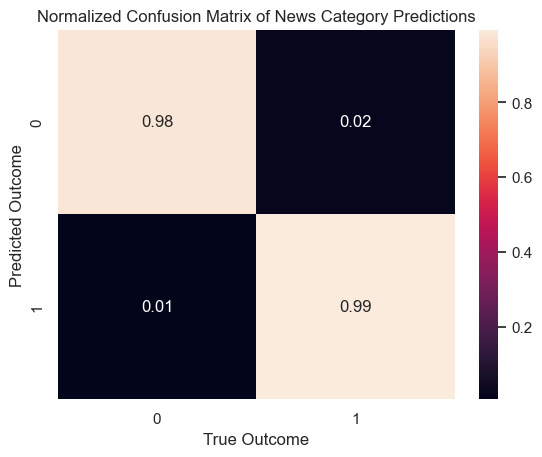

In [26]:
conf_matrix = confusion_matrix(y_test, svc_model.predict(X_test_tfidv))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt = '.2f')
_ = f.set(title = 'Normalized Confusion Matrix of News Category Predictions', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>BERT Embeddings and Multi-layer Perceptron Classifier</h2>

In [27]:
# the grid search takes a long time to run! avoid running this cell unnecessarily
estimators = {'hidden_layer_sizes': [(32,), (64,), (128,)], 'batch_size': [32, 64, 128, 256]}

mlp = MLPClassifier(solver = 'adam', random_state = 42, verbose = False, early_stopping = True, n_iter_no_change = 10)
mlp_clf = GridSearchCV(mlp, estimators, cv = 3, verbose = 3.1)
mlp_clf.fit(X_train_bert, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END batch_size=32, hidden_layer_sizes=(32,);, score=0.968 total time= 4.9min
[CV 2/3] END batch_size=32, hidden_layer_sizes=(32,);, score=0.976 total time= 5.0min
[CV 3/3] END batch_size=32, hidden_layer_sizes=(32,);, score=0.974 total time= 9.7min
[CV 1/3] END batch_size=32, hidden_layer_sizes=(64,);, score=0.970 total time= 5.0min
[CV 2/3] END batch_size=32, hidden_layer_sizes=(64,);, score=0.977 total time=10.1min
[CV 3/3] END batch_size=32, hidden_layer_sizes=(64,);, score=0.971 total time= 5.2min
[CV 1/3] END batch_size=32, hidden_layer_sizes=(128,);, score=0.977 total time=15.0min
[CV 2/3] END batch_size=32, hidden_layer_sizes=(128,);, score=0.975 total time= 9.9min
[CV 3/3] END batch_size=32, hidden_layer_sizes=(128,);, score=0.974 total time=10.6min
[CV 1/3] END batch_size=64, hidden_layer_sizes=(32,);, score=0.968 total time=   3.6s
[CV 2/3] END batch_size=64, hidden_layer_sizes=(32,);, score=0.973 total tim

GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, random_state=42),
             param_grid={'batch_size': [32, 64, 128, 256],
                         'hidden_layer_sizes': [(32,), (64,), (128,)]},
             verbose=3.1)

In [28]:
mlp_clf.best_params_, mlp_clf.best_score_

({'batch_size': 128, 'hidden_layer_sizes': (128,)}, 0.9758592471358428)

In [29]:
mlp_clf.score(X_test_bert, y_test)

0.9752480310933824

The mutli-layer perceptron classifier achieved <b>97.52% accuracy</b> on the test data. Although errors were uncommon in all three of the models evaluated, the mlp model misclassified the most real news articles. This model had fewer false positives than the extra trees model, but more than the support vector machine classifier.  

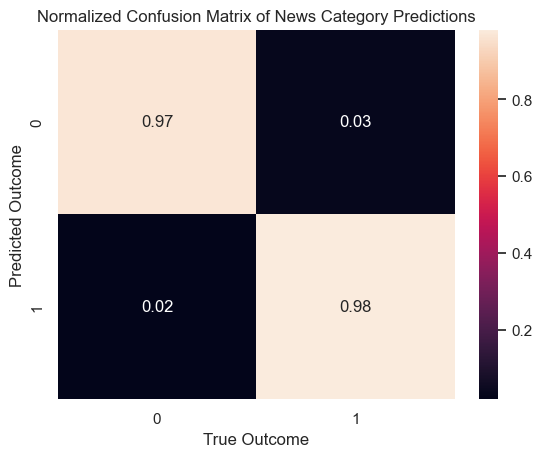

In [30]:
conf_matrix = confusion_matrix(y_test, mlp_clf.predict(X_test_bert))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt = '.2f')
_ = f.set(title = 'Normalized Confusion Matrix of News Category Predictions', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>Conclusion</h2>
<p>The support vector classifier model peforms the best out of the three models we trained. The SVC model achieves the best overall accuracy and is the most accurate at detecting fake news article. In this context, a false positive (misclassifying a fake news article as real), is more dangerous than a false negative (misclassifying a real article as fake).<p>